# Solar System

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/docs/Planets_Tutorial.ipynb)


This demo simulates the gravitational pull between multiple massive bodies.
We will use Euler steps in time which do not preserve energy.

[**Φ-Flow**](https://github.com/tum-pbs/PhiFlow)
&nbsp;&nbsp;&nbsp; [**Documentation**](https://tum-pbs.github.io/PhiFlow/)
&nbsp;&nbsp;&nbsp; [**API**](https://tum-pbs.github.io/PhiFlow/phi)
&nbsp;&nbsp;&nbsp; [**Demos**](https://github.com/tum-pbs/PhiFlow/tree/master/demos)

In [1]:
# !pip install phiflow

We use the convenience import of Φ<sub>Flow</sub> which imports the core submodules, such as `math` and `vis`.

In [2]:
from phi.flow import *

Let's define the initial positions for our planets.
We stack the position vectors of the planets a long a new [*instance*](https://tum-pbs.github.io/PhiFlow/Math.html#shapes) dimension we call *planets*.
Φ<sub>Flow</sub> also allows us to name the individual elements along that dimension. These names are part of the shape and will be present on all tensors derived from `x` that have this dimension.

In [3]:
x = stack({
    'Sun': vec(x=0, y=0),
    'Earth': vec(x=10, y=0),
    'Mars': vec(x=0, y=12)}, instance('planets'))
x

(x=0, y=0); (x=10, y=0); (x=0, y=12) (planetsⁱ=Sun,Earth,Mars, vectorᶜ=x,y)

We can plot these positions by constructing a `PointCloud`, using the `bounds` parameter to specify the axis range. Since the universe we are simulating is infinite, the `bounds` have no physical meaning in this case.

<Figure size 864x360 with 1 Axes>

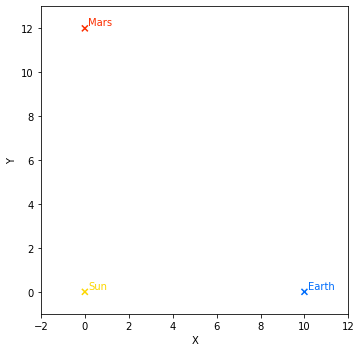

In [4]:
COLOR = wrap(['#fcd700', '#006dfc', '#fc2e00'], instance(x))
plot(PointCloud(x, bounds=Box(x=(-2, 12), y=(-1, 13))), color=COLOR)

Next, let's give the planets initial velocities so that they circle the sun.
For a nice plot, we pass the vector-valued velocities as the `values` of our `PointCloud`.

<Figure size 864x360 with 1 Axes>

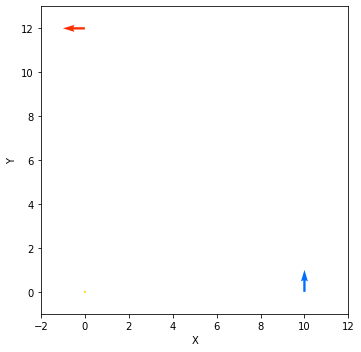

In [5]:
v = math.rotate_vector(x, PI/2)
v = math.divide_no_nan(v, math.vec_length(v))
plot(PointCloud(x, values=v, bounds=Box(x=(-2, 12), y=(-1, 13))), color=COLOR)

Next, we define the masses of our planets which will determine the gravitational pull.
These also allow us to make our plot prettier by passing a `Sphere` as the elements of the `PointCloud`.

<Figure size 864x360 with 1 Axes>

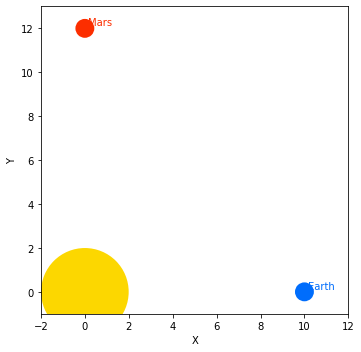

In [6]:
masses = math.stack({'Sun': 1000, 'Earth': 10, 'Mars': 10}, instance('planets'))
plot(PointCloud(Sphere(x, radius=masses**0.333 * .2), bounds=Box(x=(-2, 12), y=(-1, 13))), color=COLOR)

To Simulate our system, we define a simple update step, `simulation`, and iterate it to produce the position and velocity trajectories `xs` and `vs`.
We use `iterate` instead of a `for`-loop because `iterate` can also stack all intermediate values to give us the full trajectory along the newly-defined `time` axis.
This saves us from creating two lists, adding every element and manually stacking the values.

Inside the simulation step, `math.pairwise_distances` computes all body-body distances, adding a new instance dimension with the name `others` by default.

In [7]:
def simulate(x, v, dt=.5):
    dx = math.pairwise_distances(x)
    a = .01 * math.sum(math.divide_no_nan(masses.planets.as_dual() * dx, math.vec_squared(dx) ** 1.5), '~planets')
    return x + v * dt, v + a * dt

xs, vs = iterate(simulate, batch(time=100), x, v)
xs

(timeᵇ=101, planetsⁱ=Sun,Earth,Mars, vectorᶜ=x,y) -2.464 ± 7.704 (-2e+01...1e+01)

Let's plot the system trajectory as an animation!
We can use the `time` dimension created above for the animation.
Using `vis.overlay` allows us to plot multiple fields in one figure.

In [8]:
plot(vis.overlay(
    PointCloud(Sphere(xs, radius=masses ** 0.333 / 5), bounds=Box(x=(-20, 20), y=(-20, 20))),
    PointCloud(xs, vs * 2, bounds=Box(x=(-20, 20), y=(-20, 20)))), animate='time', frame_time=100, color=COLOR)